# Тестовое задание
<br>

### Общее описание
В этом задании Вам необходимо реализовать и обучить алгоритмы DDPG и TD3, а затем сравнить резульаты, полученные данными алгритмами. Тестирование проводится с помощью одной из классических сред LunarLanderContinuous, которая входит в библиотеку OpenAI Gym.<br><br>
При решении задачи крайне приветствуется внесение в алгоритмы спецефичных для данной задачи модификаций.

### Критерии оценки

* Задача полностью решена, если агент в среднем достигает 220+ очков
* Задача решена удовлетворительно, если агент в среднем достигает 50+ очков
* Помимо результатов обучения агента, также оценивается качество кода и анализа результатов

In [ ]:
# Код для установки пакетов в Google Colab
!pip install Box2D  > /dev/null 2>&1
!pip install gym[all] pyvirtualdisplay > /dev/null 2>&1
!pip install tqdm > /dev/null 2>&1
!apt update > /dev/null 2>&1
!apt install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
import gym
import time
import matplotlib.pyplot as plt
import copy
import random
import numpy as np
from collections import deque
from itertools import chain

# PyTorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from tqdm.notebook import tqdm

# Устройство, на котором будет работать PyTorch.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Model trains faster in GPU

%matplotlib inline
device

device(type='cuda')

In [ ]:
# Буфер опыта
# Тут ничего менять не нужно

class ExpirienceReplay:
    def __init__(self, size=10000):
        self.data = deque(maxlen=size)
    
    def add(self, transition):
        self.data.append(transition)
        
    def sample(self, size):
        batch = random.sample(self.data, size)
        return list(zip(*batch))

In [ ]:
#title Метод build_plot для отрисовки графиков
# Тут ничего менять не нужно

def build_plot(xs, means, stds, labels, figsize=(12, 8)):
    colors = [
        (0.8, 0.0, 0.0),
        (0.0, 0.8, 0.0),
        (0.0, 0.0, 0.8),
        (0.0, 0.5, 0.8)
    ]
    x_min = max([x[0] for x in xs])
    x_max = min([x[-1] for x in xs])
    plt.figure(figsize=figsize)
    plt.plot([x_min, x_max], [150., 150.], color=(0.25, 0.25, 0.25, 0.6), linestyle='-.', label="Minimal solution")
    plt.plot([x_min, x_max], [300., 300.], color=(0.75, 0.75, 0.0, 0.6), linestyle='-.', label="Optimal solution")
    for x, mean, std, label, color in zip(xs, means, stds, labels, colors):
        plt.fill_between(x, mean - 2*std, mean + 2*std, color=color, alpha=0.2)
        plt.plot(x, mean, label=label, color=color)
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.ylim(-300, 300)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
#title Методы train и test
# Тут ничего менять не нужно

ACTION_SIZE = 2
STATE_SIZE = 8
ENV_NAME = "LunarLanderContinuous-v2"

def test(ddpg, episodes=10):
    rewards = []    
    env = gym.make(ENV_NAME)
    for _ in range(episodes):
        sum_reward = 0
        done = False
        state = env.reset()
        while not done:
            state, reward, done, _ = env.step(ddpg.get_action(state))
            sum_reward += reward
        rewards.append(sum_reward)
    return np.mean(rewards), np.std(rewards)

def train(agent, timesteps=50000, batch_size=256, buffer_size=50000, 
          start_train=10000, test_every=1000, test_count=10):
    env = gym.make(ENV_NAME)
    env.seed(0)
    random.seed(0)
    done = False
    state = env.reset()
    buffer = ExpirienceReplay(buffer_size)
    actor_loss_sum = 0
    critic_loss_sum = 0
    loss_ctn = 0
    
    log_ts = []
    log_mean = []
    log_std = []
    
    rng = tqdm(range(timesteps))
    for t in rng:
        if done:
            done = False
            state = env.reset()
        action = np.clip(agent.get_action(state) + np.random.randn(ACTION_SIZE)*0.15, -1, 1)
        next_state, reward, done, _ = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
        
        if t > start_train:
            batch = buffer.sample(batch_size)
            critic_loss, actor_loss = agent.update(batch)
            actor_loss_sum += actor_loss
            critic_loss_sum += critic_loss
            loss_ctn += 1
            
            if t % test_every == 0 or t == timesteps - 1:
                log_ts.append(t)
                mean, std = test(agent, test_count)
                log_mean.append(mean)
                log_std.append(std)
                rng.set_postfix_str(f"Mean reward: {mean:.2f}, Critic loss: {(critic_loss_sum / loss_ctn):.2f}, Actor loss: {(actor_loss_sum / loss_ctn):.2f}")
                actor_loss_sum = 0
                critic_loss_sum = 0
                loss_ctn = 0

    return np.array(log_ts), np.array(log_mean), np.array(log_std)

### Задание
Вам нужно заполнить пробелы в коде ниже. Код взаимодействия со средой уже реализован за Вас.

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_size: int, action_size: int, hidden_size: int, hidden_size_2: int = 400):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, action_size)
        
    def forward(self, state):
        """
        Принимает на вход state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Возвращает объект класса torch.Tensor размерности (batch_size, action_size), который является предсказанным действием агента
        """
        out = F.relu(self.fc1(state))
        out = F.relu(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        return out

In [ ]:
class Critic(nn.Module):
    def __init__(self, state_size: int, action_size: int, hidden_size: int, hidden_size_2: int = 400):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size+action_size, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, 1)
        
    def forward(self, state, action):
        """
        Принимает на вход state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Принимает на вход action, который является объектом класса torch.Tensor и имеет размерность (batch_size, action_size)
        Возвращает объект класса torch.Tensor размерности (batch_size, ), который является оценкой Q-function
        """
        out_state = F.relu(self.fc1(state))
        out = torch.cat((out_state, action), dim=1)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out 

In [ ]:
class DDPG:
    def __init__(self, state_size, action_size, tau=0.001, gamma=0.99, hidden_size=256,
                 hidden_size_2: int = 400, actor_lr: float = 1e-3, critic_lr: float = 1e-3):
        self.gamma = gamma
        self.tau = tau
        self.actor = Actor(state_size, action_size, hidden_size, hidden_size_2)
        self.critic = Critic(state_size, action_size, hidden_size, hidden_size_2)
        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)
        
        self.actor.to(device)
        self.target_actor.to(device)
        self.critic.to(device)
        self.target_critic.to(device)
        
        self.actor_optim = optim.AdamW(self.actor.parameters(), lr=actor_lr)
        self.critic_optim = optim.AdamW(self.critic.parameters(), lr=critic_lr)
        
    def get_action(self, state):
        """
        Принимает на вход state, который является объектом класса numpy.array
        Возвращает action, который является объектом класса numpy.array
        """
        state_tensor = torch.from_numpy(state).to(device)
        action = self.actor(state_tensor).detach().cpu().numpy()
        return action
        
    
    def compute_actor_loss(self, state):
        """
        Принимает на вход state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Возвращает функцию потерь actor'а loss, которая явлеятся объектом класса torch.Tensor
        """
        loss = -self.critic(state, self.actor(state)).mean()
        return loss
    
    def compute_critic_loss(self, state, action, next_state, reward, done):
        """
        Принимает на вход state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Принимает на вход action, который является объектом класса torch.Tensor и имеет размерность (batch_size, action_size)
        Принимает на вход next_state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Принимает на вход reward, который является объектом класса torch.Tensor и имеет размерность (batch_size, )
        Принимает на вход done, который является объектом класса torch.Tensor и имеет размерность (batch_size, ) и тип bool
        Возвращает функцию потерь critic'а loss, которая явлеятся объектом класса torch.Tensor
        """
        with torch.no_grad():
            q_value = self.target_critic(next_state, self.target_actor(next_state))
            y = self.gamma * (torch.ones(done.shape, device=device) - done.long()).unsqueeze(1) * q_value
            y += reward.unsqueeze(1)
        loss = F.mse_loss(self.critic(state, action), y)
        return loss
    
    def soft_update(self, target_net, source_net):
        """
        Применяет soft update с коэффициентом self.tau обновляя параметры target_net с помощью параметров source_net
        """
        for target_param, source_param in zip(target_net.parameters(), source_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + source_param.data * self.tau)
        
    
    def update(self, batch):
        state, action, next_state, reward, done = batch
        state = torch.tensor(state, dtype=torch.float32, device=device)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device).view(-1)
        done = torch.tensor(done, device=device)
        action = torch.tensor(action, device=device, dtype=torch.float32)
        
        actor_loss = self.compute_actor_loss(state)
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        # Actor soft update
        self.soft_update(self.target_actor, self.actor)

        critic_loss = self.compute_critic_loss(state, action, next_state, reward, done)
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()
            
        # Critic soft update
        self.soft_update(self.target_critic, self.critic)

        return critic_loss.item(), actor_loss.item()

In [ ]:
class TD3(DDPG):
    def __init__(self, state_size, action_size, tau=0.001, gamma=0.99, hidden_size=256, 
                 hidden_size_2: int = 400, noise_clip: float = 0.5, policy_noise: float = 0.2, 
                 policy_delay: int = 2, actor_lr: float = 1e-3, critic_lr: float = 1e-3):
        super().__init__(state_size, action_size, tau, gamma, hidden_size)
        # TODO: Add TD3-specific modifications (e.g. second critic)
        self.noise_clip = noise_clip
        self.policy_noise = policy_noise
        self.policy_delay = policy_delay
        self.count_policy_delay = 0 # чтобы не вносить изменения в код трейна, счетчик будет полем класса
        self.actor = Actor(state_size, action_size, hidden_size, hidden_size_2)
        self.critic = Critic(state_size, action_size, hidden_size, hidden_size_2)
        self.second_critic = Critic(state_size, action_size, hidden_size, hidden_size_2)
        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)
        self.target_second_critic = copy.deepcopy(self.second_critic)
        
        self.actor.to(device)
        self.target_actor.to(device)
        self.critic.to(device)
        self.target_critic.to(device)
        self.second_critic.to(device)
        self.target_second_critic.to(device)
        
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optim = optim.Adam(chain(self.critic.parameters(), self.second_critic.parameters()), 
                                             lr=critic_lr)
    
    def compute_critic_loss(self, state, action, next_state, reward, done):
        """
        Принимает на вход state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Принимает на вход action, который является объектом класса torch.Tensor и имеет размерность (batch_size, action_size)
        Принимает на вход next_state, который является объектом класса torch.Tensor и имеет размерность (batch_size, state_size)
        Принимает на вход reward, который является объектом класса torch.Tensor и имеет размерность (batch_size, )
        Принимает на вход done, который является объектом класса torch.Tensor и имеет размерность (batch_size, ) и тип bool
        Возвращает функцию потерь critic'а loss, которая явлеятся объектом класса torch.Tensor
        """
        # TODO: Add TD3-specific modifications
        with torch.no_grad():
            noise = (torch.randn_like(action) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
            next_action = (self.target_actor(next_state) + noise).clamp(-1, 1)
            q1 = self.target_critic(next_state, next_action)
            q2 = self.target_second_critic(next_state, next_action)
            q_value = torch.min(q1, q2)
            y = self.gamma * (torch.ones(done.shape, device=device) - done.long()).unsqueeze(1) * q_value
            y += reward.unsqueeze(1)
        loss = F.mse_loss(self.critic(state, action), y) + F.mse_loss(self.second_critic(state, action), y)
        return loss

    
    def update(self, batch):
        # Don't forget to update second critic here!
        state, action, next_state, reward, done = batch
        state = torch.tensor(state, dtype=torch.float32, device=device)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device).view(-1)
        done = torch.tensor(done, device=device)
        action = torch.tensor(action, device=device, dtype=torch.float32)

        critic_loss = self.compute_critic_loss(state, action, next_state, reward, done)
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        self.count_policy_delay += 1

        if self.count_policy_delay % self.policy_delay == 0:
            actor_loss = self.compute_actor_loss(state)
            self.actor_optim.zero_grad()
            actor_loss.backward()
            self.actor_optim.step()

            self.soft_update(self.target_actor, self.actor)

            self.soft_update(self.target_critic, self.critic)
            self.soft_update(self.target_second_critic, self.second_critic)
        else:
            actor_loss = torch.zeros(1)  # чтобы return корректно возвращал, что надо        

        return critic_loss.item(), actor_loss.item()

### Запуск обучения агента
Не забудьте потьюнить гиперпараметры для лучшего результата!

In [ ]:
xs, means, stds, labels = [], [], [], []

In [ ]:
ddpg = DDPG(STATE_SIZE, ACTION_SIZE, tau=0.001, gamma=0.99, hidden_size=256, hidden_size_2=356, 
            actor_lr=1e-3, critic_lr=1e-3)
x, mean, std = train(ddpg, timesteps=400_000, test_every=5000,
                     batch_size=256, start_train=20000, buffer_size=50000, test_count=5)
xs.append(x)
means.append(mean)
stds.append(std)
labels.append(f"DDPG")

final_mean, final_std = test(ddpg, episodes=25)
print(f"Agent mean score is {final_mean} with std {final_std}")

  0%|          | 0/400000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Agent mean score is 289.4741205589016 with std 20.93138518878587


In [ ]:
td3 = TD3(STATE_SIZE, ACTION_SIZE, tau=0.005, gamma=0.99, hidden_size=256,
          noise_clip=0.5, policy_noise=0.2, 
          policy_delay=2, actor_lr=3e-4, critic_lr=3e-4)
x, mean, std = train(td3, timesteps=400_000, test_every=5000,
                     batch_size=256, start_train=20000, buffer_size=50000, test_count=5)
                     
xs.append(x)
means.append(mean)
stds.append(std)
labels.append(f"TD3")

final_mean, final_std = test(td3, episodes=25)
print(f"Agent mean score is {final_mean} with std {final_std}")

  0%|          | 0/400000 [00:00<?, ?it/s]

Agent mean score is 284.0660787510597 with std 18.464298030286475


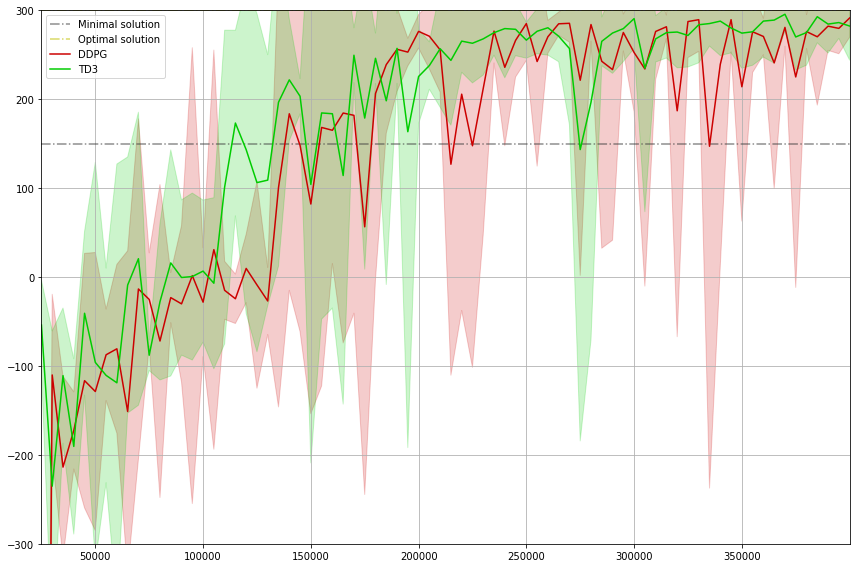

In [ ]:
build_plot(xs, means, stds, labels)

Как видно из графика, оба алгоритма почти сошлись к оптимальному решению (300+ очков), и если продолжить обучение, то они скорее всего сойдутся. TD3 является более устойчивым алгоритмом, отклонение реворда у него меньше, особенно это заметно после 300_000 эпизода, в то время как DDPG ведет себя нестабильно. Этого и следовало ожидать, потому что у TD3 два критика, также обновление таргет-сетей не на каждом апдейте, что, интуитивно, должно вести к более стабильной сходимости. \
Было испробовано несколько вариантов гиперпараметров (в освном происходил тюнинг lr, hidden_state, tau), у DDPG был заменен Adam на AdamW, но дополнительный weight_decay не дал существенного улучшения результата. \
Также был добавлен параметр hidden_state_2 для сетей актора и критика, но добавление еще одного dense слоя также не дало существенного улучшения. \

